# Recap on reparameterization

Reparameterization allows us to use gradient optimization to fit a proposal distribution $q_\theta(z)$ to the posterior by optimizing the ELBO. In this lecture you will see how to achieve the same goal but with using a richer family of possible $q_\theta(z)$. You will be introduced to these families of models, and be given enough time to try to understand how we can compute gradients and optimize the parameters.

### Outline
* Review of estimating gradients over expectations: reparameterization
* How to implement reparameterization on pytorch
* How to implement gradient estimators when the variational family is semi-implicit



### Interchanging partial derivatives and integrals


Start considering the euclidean partial derivative of a integral of a parametric function:
$$ \frac{\partial}{\partial \theta_i} \int_{z \in \mathcal{Z}} f(z)q_\theta(z) dz = \lim_{s \rightarrow 0} \frac{1}{s}\int_{z \in \mathcal{Z}} f(z)[q_{\theta+se_i}(z)-q_{\theta}(z)] dz$$
$$ \Rightarrow \frac{\partial}{\partial \theta_i} \int_{z \in \mathcal{Z}} f(z)q_\theta(z) dz = \lim_{s \rightarrow 0} \int_{z \in \mathcal{Z}} f(z)\frac{[q_{\theta+se_i}(z)-q_{\theta}(z)]}{s} dz$$
$$ \Rightarrow \frac{\partial}{\partial \theta_i} \int_{z \in \mathcal{Z}} f(z)q_\theta(z) dz = \int_{z \in \mathcal{Z}} f(z)\frac{\partial}{\partial \theta_i}q_{\theta}(z)] dz$$

Considering that the integral $\int_{z \in \mathcal{Z}} f(z)q_\theta(z) dz$ exist and that the function is bounded and differentiable over the parameter space of $\theta$, consider a small perturbation of step $s>0$ on the canonical direction $e_i$ denotated by  $\theta+d\theta=\theta+se_i$. Then the integral $\int_{z \in \mathcal{Z}} f(z)q_{\theta+se_i}(z) dz$ also exist. Given that both integral exists we can substract them and divide by $h$ obtaining the final results.

The intuition here is that if the function value is bounded, differentiable and smooth on the parameter $\theta$ it means that we can always build the integral over small changes of the parameter, and calculate the differential of interest. Since we assume that the function is differentiable, taking the limit of $s \rightarrow 0$ will converge to $\frac{\partial}{\partial \theta_i}q_{\theta}(z)$.

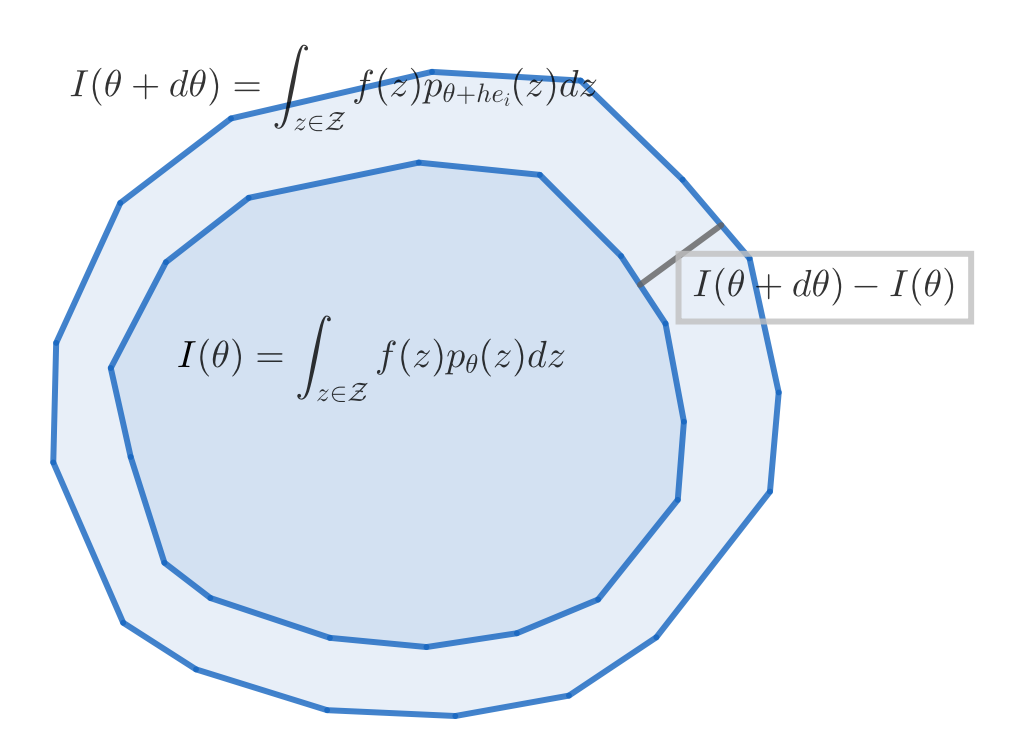


### Gradient operator over a expected value

Given a value of interested expressed in terms of a expected value parameterized by $\theta$, denotated as $L(\theta) = E_{z \sim q_\theta(z)}[f(z)] $ we wish to estimate derivatives with respect to the parameter $\theta$. If we assume the function and pdf is bounded and differentiable, we proceed by interchanging the gradient with the expectation, similarly with the previous section.

$$ \nabla_\theta E_{z \sim q_\theta(z)}[f(z)] = \nabla_\theta \int_{z \in \mathcal{Z}} f(z)q_\theta(z) dz$$

$$ =  \int_{z \in \mathcal{Z}} \nabla_\theta[f(z) q_\theta(z)] dz$$

This can be further simplified if we noticed that $\nabla f = f \nabla \text{log} f$
$$ \Rightarrow \nabla_\theta E_{z \sim q_\theta(z)}[f(z)] =  \int_{z \in \mathcal{Z}} f(z)q_\theta(z)\nabla_\theta\text{log}[f(z) q_\theta(z)] dz$$
$$ \nabla_\theta E_{z \sim q_\theta(z)}[f(z)] =   E_{z \sim q_\theta(z)}[ f(z)\nabla_\theta \text{log} [f(z)q_\theta(z)] ]$$

This is now a gradient estimator for the gradient of our expected value that depends only on computing the gradient of the log of the function inside of the expected value and sampling values of $z$. We can create now and Monte Carlo estimator for the gradient with a finite amount $C$ of samples:

$$ \nabla_\theta E_{z \sim q_\theta(z)}[f(z)] \approx \frac{1}{C}   \sum_{z \sim q_\theta(z)} f(z)\nabla_\theta \text{log} [f(z)q_\theta(z)] $$

If we can easily compute $\nabla_\theta \text{log} [f(z)q_\theta(z)]$ the problem is solved. If $\nabla_\theta f(z) = 0$, this estimator reduces to summing over
$f(z)\nabla_\theta \text{log} q_\theta(z) $. This is also know as the *score function estimator*, or REINFORCE estimator. 

In the case that $\nabla_\theta \text{log} [f(z)q_\theta(z)]$ is not easily computable, we can resort to reparameterize $z \sim q_\theta(z)$ in a way that we can sample from a simple distribution and the dependency on $\theta$ comes from a transformation of that sample. 

Namely $\epsilon \sim p(\epsilon)$ and $z = h_\theta(\epsilon)$ is equivalent to $z \sim q_\theta(z)$. This way we can apply the chain rule and simplify the gradient computation.

$$\nabla_\theta \text{log} [f(z)q_\theta(z)]=\nabla_\theta \text{log}f(z)+\nabla_\theta \text{log} q_\theta(z) $$
$$\Rightarrow  \nabla_\theta \text{log} [f(z)q_\theta(z)] = \nabla_z \text{log}f(z)|_{z=h_\theta(\epsilon)}\nabla_\theta z +\nabla_z \text{log} q_\theta(z)|_{z=h_\theta(\epsilon)} \nabla_\theta z $$
$$\Rightarrow  \nabla_\theta \text{log} [f(z)q_\theta(z)] = \left(\nabla_z \text{log}f(z)|_{z=h_\theta(\epsilon)}+\nabla_z \text{log} q_\theta(z)|_{z=h_\theta(\epsilon)}\right)\nabla_\theta h_\theta(\epsilon) $$

Now as long as $\text{log} f$ and $\text{log} p$ are differentiable with respect to their argument $z$ and the parameterized transformation $z = h_\theta(\epsilon)$ is differentiable with respect to the parameter $\theta$ wen can build a estimator for $\nabla_{\theta} L(\theta)$ using the following algorithm:
- Generate $C$ samples from $\epsilon_i \sim p(\epsilon)$
- Set $\text{grad} = 0$
- for each $\epsilon_i$:
  - Calculate $z_i = h_\theta(\epsilon_i)$
  - Calculate $g(z_i) = \nabla_z \text{log}f(z)|_{z=z_i}+\nabla_z \text{log} q_\theta(z)|_{z=z_i}$
  - Calculate $v(z_i, \theta) = f(z_i)g( z_i )\nabla_\theta h_\theta(\epsilon_i) $
    - alternatively we can write this as $v(z_i, \theta)= f(z_i)g( z_i )\nabla_\theta z_i $
  - Set $ \text{grad} = \text{grad} +v(z_i, \theta)$ 
- Set $\text{grad} = \text{grad} / C$
- Return $\text{grad}$

### Dimensionality of the variables

- $f(z)$ and $p_\theta(z)$ are vector-to-scalar mappings. If we use the notation of shape for tensors, we can say that `shape(f(z))=[1]`, while `shape(z)=[1,n]`. Consequentially the gradient $\nabla_z \text{log} f(𝑧)$ should have the same dimensionality as $z$ (depending on the particular implementation it might be the transposed shape, or the same shape, in `torch` it is the same shape).

In the example below we demonstrate this and also how the automatic differentiation module of pytorch can be used to compute derivatives. In this example we use $f(z) = \text{log}(\sum_k z_k^2)$ with $\nabla_z f(z) = \frac{2}{\sum_k z_k^2}z$


In [ ]:
import torch
from torch.autograd import grad

z=torch.autograd.Variable(torch.tensor([[1.0,2.0]]), requires_grad=True)
print(f"z={z}, shape(z)={z.shape}")
f_z = lambda z: torch.log(torch.sum(z**2))

print(f"grad(f_z(z),z)={grad(f_z(z),z)[0]}, shape(grad)={grad(f_z(z),z)[0].shape}")


z=tensor([[1., 2.]], requires_grad=True), shape(z)=torch.Size([1, 2])
grad(f_z(z),z)=tensor([[0.4000, 0.8000]]), shape(grad)=torch.Size([1, 2])


- We know that $z = h_\theta(\epsilon) $ is a vector-to-vector mapping from the space of parameter $\theta$ and random variable $\epsilon$ to the space of variable $z$. Calculating $\nabla_\theta h_\theta(\epsilon) $ means calculating the Jacobian, collecting all partial derivatives of all components of $z$ with respect to all components of $\theta$. If the shape of $\theta$ is `[1,m]` and the shape of $z$ is `[1,n]`, then the shape of the Jacobian is `[n,m]`.
- When we are multiplying $\nabla_z \text{log} f(𝑧) \nabla_\theta h_\theta(\epsilon) $ we are performing then a multiplication with shapes `[1,n]` and `[n,m]`, resulting in a tensor with shape `[1,m]`, which is the shape of the tensor $\theta$.

More on pytorch autograd: https://jhui.github.io/2018/02/09/PyTorch-Variables-functionals-and-Autograd/



In [ ]:
import torch
from torch.nn import Linear
from torch.autograd import grad

epsilon = torch.tensor([[1.0,2.0,1.0,6.0]])
h_theta = Linear(4,2,False)

z_s = h_theta(epsilon)
theta = list(h_theta.parameters())[0]
print(f"theta[0]={theta[0]}, shape(theta)={theta.shape}")

# function f
f_z = lambda z: torch.log(torch.sum(z**2))

# method 1 for ∇𝑓(𝑧)∇ℎ𝜃(𝜖): calculate directly grad(𝑓(𝑧), theta)
grad_theta_1 = grad(f_z(z_s), theta, retain_graph=True)[0]
print(f"grad_theta_1[0]={grad_theta_1[0]}, shape(grad_theta_1)={grad_theta_1.shape}")


theta[0]=tensor([-0.4790,  0.0357,  0.1495, -0.0092], grad_fn=<SelectBackward>), shape(theta)=torch.Size([2, 4])
grad_theta_1[0]=tensor([-0.2339, -0.4679, -0.2339, -1.4037]), shape(grad_theta_1)=torch.Size([2, 4])


These code snippets show how we can use the automatic differentiation methods in two different ways to obtain the correct result for $\nabla_z \text{log} f(𝑧) \nabla_\theta h_\theta(\epsilon) $. Method 2 is particularly interesting for the UIVI method because it allow us to customized the gradient with respect to $z$, while maintaining the correct application of the chain rule. It works well because $\nabla_\theta \left(\sum_{k=1}^{n} a_k z_{k}\right)_{k'}=\frac{\partial \sum_{k=1}^{n} a_k z_{k}}{\partial z_{k'}}\nabla_\theta z_{k'}=a_{k'}\nabla_\theta z_{k'}$, so it $a_k = \frac{\partial \text{log} f(𝑧) }{\partial z_k}$ we can compute  $\nabla_z \text{log} f(𝑧) \nabla_\theta h_\theta(\epsilon) $ by first calculating  $a = \nabla_z \text{log} f(𝑧) |_{z=h_\theta(\epsilon)}$, and then calculating the gradient of $a^{\top}z|_{z=h_\theta(\epsilon)}$ with respect to $theta$, with $a$ now as a constant.

In [ ]:
z=torch.autograd.Variable(z_s.detach(), requires_grad=True)
print(f"z={z.data}, shape(z)={z.shape}")

grad_f_z = grad(f_z(z),z)[0]
print(f"grad_f_z={grad_f_z}, shape(grad_f_z)={grad_f_z.shape}")
# method 2 for ∇𝑓(𝑧)∇ℎ𝜃(𝜖): explicit calculate a=∇𝑧𝑓(𝑧), detach from the computation graph and explicit multiply by z
# sum over the dimension such that when when we call grad(sum(a𝑧), theta), we obtain a∇𝜃ℎ𝜃(𝜖)
sum_grad_f_z = torch.einsum('i...,i...->',grad_f_z.detach(), z_s)
grad_theta_2 = grad(sum_grad_f_z, theta, retain_graph=True)[0]
print(f"grad_theta_2[0]={grad_theta_2[0]}, shape(grad_theta_2)={grad_theta_2.shape}")

z=tensor([[-0.3131, -1.6059]]), shape(z)=torch.Size([1, 2])
grad_f_z=tensor([[-0.2339, -1.1998]]), shape(grad_f_z)=torch.Size([1, 2])
grad_theta_2[0]=tensor([-0.2339, -0.4679, -0.2339, -1.4037]), shape(grad_theta_2)=torch.Size([2, 4])


# Semi-implicit VI



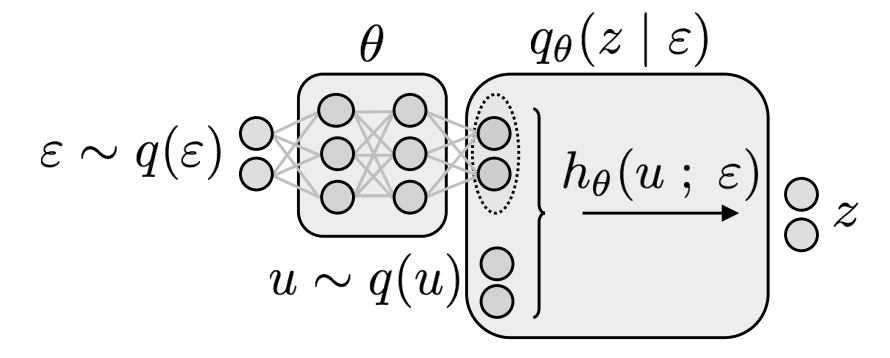

### Exercise 1

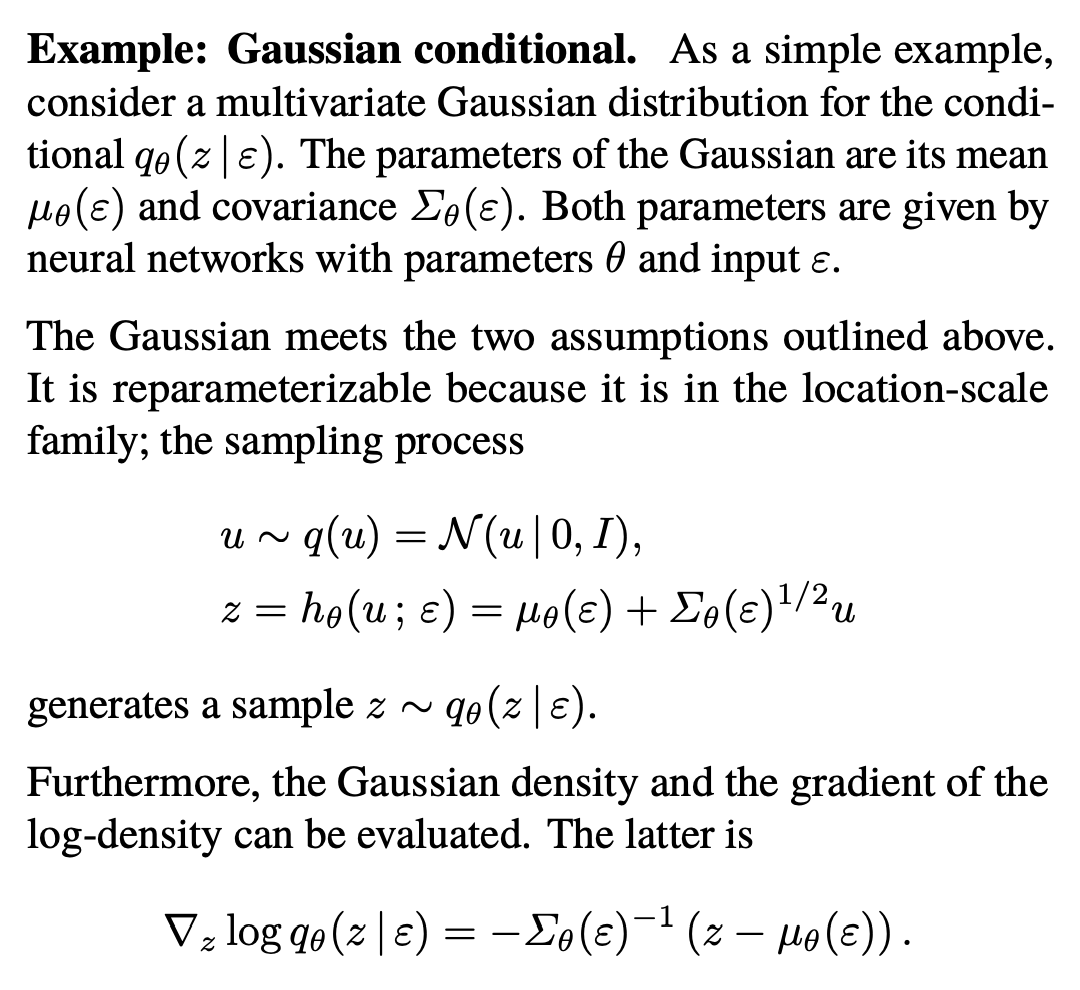

* Use the Gaussian implementation in `torch.distributions` and the automatic gradient method in `torch.autograd` to implement the Gaussian conditional model above and compute $\nabla_z \text{log} q_\theta(z|\epsilon) $. Compare your solution to the analytical one provided. 
    * Start by implementing the semi-implicit distribution, parameterized the mean and the covariance, and in order to simplify the task you can model the covariance as a diagonal matrix.
    * Use the definition of the Gaussian PDF to show the analytical result
    * Figure out how you can use the automatic gradient tool for computing the conditional log-likelihood




## Unbiased implicit gradient estimator

### UIVI - Unbiased Implicit Variational Inference

Using semi-implicit family distributions parameterized by $\theta$ we can re-work the ELBO to be expressed as 

$$L(\theta) = \text{E}_{q(u)q(\epsilon)}[ \{\text{log} p(x,z) - \text{log} q_\theta(z)\}|_{z=h_\theta(u,\epsilon)}]$$

The way to understand this loss is that we sample $\epsilon$ and $u$ from a simple distribution, pass them through the parameterized NN to generate $z$ and evaluate the log-likelihood of your model and of the variational proposal distribution. If we compute the gradients with respect to $\theta$ for the  

$$\nabla_\theta L(\theta) = \text{E}_{q(u)q(\epsilon)}[ \{ \nabla_z \text{log} p(x,z) - \nabla_z \text{log} q_\theta(z)\}|_{z=h_\theta(u,\epsilon)} \nabla_\theta h(u, \epsilon)]$$

which we can conclude that $\nabla_z \text{log} p(x,z) \nabla_\theta h(u, \epsilon)$ can be easily computed by automatic differentiation, but $\nabla_z \text{log} q_\theta(z)|_{z=h_\theta(u,\epsilon)}$ is not easily computable for the case of semi-implicit distribution, because we need to compute  $ q_\theta(z) = \int q_\theta(z | \epsilon) q(\epsilon) d\epsilon $. Nevertheless we can rewrite it as an expectation over the posterior $q(\epsilon' | z)$.

$$ \nabla_z \text{log} q_\theta(z) = \text{E}_{q(\epsilon' | z)} [ \nabla_z \text{log} q_\theta(z|\epsilon) ]$$

We can implement this using a combination of `torch.distributions` to compute $\nabla_z \text{log} q_\theta(z|\epsilon)$ (as in previous exercise) while summing over samples from this posterior $q(\epsilon' | z)$. For this posterior we need to use HMC (which in our code is done using `pyhmc`).

### SIVI - Doubly Semi-Implicit Variational Inference


In the case of SIVI this problem is tackled by creating another objective that is a lower-bound to the original objective (and be seen as an approximation to that objective). 


$$L^{\text{SIVI}}(\theta) = \text{E}_{\epsilon \sim q(\epsilon)}[ \text{E}_{z \sim q(z | \epsilon)} [ \text{E}_{\epsilon_1 , ..., \epsilon_L \sim q(\epsilon)} [f_\theta(\epsilon, z, e_1, .. e_L)]]]$$

With

$$f_\theta(\epsilon, z, e_1, .. e_L)=\{\text{log} p(x,z) - \text{log}(\frac{1}{L+1}( q_\theta(z|\epsilon)+ \sum_{i=1}^L  q_\theta(z|\epsilon_i))\}|_{z=h_\theta(u,\epsilon)} $$

($u$ here is implicit in the sampling $z \sim q(z | \epsilon)$ )

# Implementing the methods

In [4]:
!pip install pyhmc
!pip install statsmodels
!pip install pyro-ppl

  Created wheel for pyhmc: filename=pyhmc-0.1.2-cp37-cp37m-linux_x86_64.whl size=534180 sha256=28f785ce1105534a3cb65d9f1753e1d51773a7ba5bcaf9d13b152e887fedc425
  Stored in directory: /root/.cache/pip/wheels/ea/4b/9b/b015501599762ef907ce9de56171550fc2af2add90d524c63d
Successfully built pyhmc
     |████████████████████████████████| 634kB 6.5MB/s 


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as td
import torch.nn as nn
from torch.autograd import Variable
import random
from pyhmc import hmc
import numpy as np
from tqdm.notebook import trange, tqdm
np.random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exercises

- **Main**: Implement `grad_z_log_q_z(self, z_s)`, which should return $\nabla_z \text{log} q_\theta(z) |_{z=z_s}$ using the idea presented of UIVI.
  - You will be provided with the samples from the HMC already. You can return this gradient as a simple array (either python list or numpy array)

- *Extra*: Implement `sivi_lb_grad_z(self, obs, z_s, l_tightness=10)`, which should return `grad_z_log_q, grad_z_log_p` meaning $\nabla_z \text{log} p(x,z) |_{z=z_s}$ and $\nabla_z \text{log} q_\theta(z) |_{z=z_s}$ using the idea presented of SIVI.
  - You will be provided with the samples and you need to implement the operations for estimating the stochastic gradients

In [19]:
class implicit_vi_student:
    def __init__(self, model, in_dim=3, z_dim=2, theta_dim=5, n_samples_epsilon=5, n_runs=10):
        self.in_dim = in_dim
        self.z_dim = z_dim
        self.theta_dim = theta_dim
        self.n_samples_epsilon = n_samples_epsilon
        self.n_runs = n_runs

        self.epsilon = td.multivariate_normal.MultivariateNormal(torch.zeros(self.in_dim), torch.diag(torch.ones(self.in_dim)))
        self.model = model
        self.initial_epsilon = None
        self.current_q_conditional = None

        # location parameter of q(z | epsilon)
        self.q_loc = nn.Sequential(nn.Linear(self.in_dim, self.theta_dim), nn.ReLU(), 
                                   nn.Linear(self.theta_dim, self.theta_dim), nn.ReLU(),
                                   nn.Linear(self.theta_dim, self.z_dim))
        # scale parameter
        self.q_scale = nn.Sequential(nn.Linear(self.in_dim, self.theta_dim), nn.ReLU(), nn.Linear(self.theta_dim,
                                                                                                  2* self.z_dim),
                                     nn.ReLU(), nn.Threshold(0.001, 0.001),
                                     nn.Unflatten(dim=0, unflattened_size=(2, self.z_dim)))

    def q_z_conditional_epsilon(self, epsilon_s):
        # q_theta( z | f(epsilon))
        scale_mat = torch.matmul(self.q_scale(epsilon_s)[0].unsqueeze(1), self.q_scale(epsilon_s)[0].unsqueeze(1).t())
        scale_mat = scale_mat + torch.diag(self.q_scale(epsilon_s)[1])

        q_z_epsilon = td.multivariate_normal.MultivariateNormal(self.q_loc(epsilon_s),  covariance_matrix=scale_mat)

        return q_z_epsilon

    def parameters(self):
        return list(self.q_scale.parameters()) + list(self.q_loc.parameters())

    def sample_epsilon(self):
        epsilon = self.epsilon.rsample()
        self.initial_epsilon = epsilon.detach().numpy()
        self.current_q_conditional = self.q_z_conditional_epsilon(epsilon)
        return epsilon

    def sample_z(self, epsilon):
        conditional_q = self.q_z_conditional_epsilon(epsilon)
        z_s = conditional_q.rsample()
        return z_s

    def forward(self):
        epsilon = self.sample_epsilon()
        z_s = self.sample_z(epsilon)
        return z_s

    def sample_posterior(self, n_samples=5):
        ## auxiliary function for returning z after training for plotting
        res = []
        with torch.no_grad():
            for _ in range(n_samples):
                z = self.forward()
                res.append(z)
        return res

    def grad_z_log_q_z(self, z_s):
        # Equation 8: sum_{epsilon_s ~ q(epsilon | z)} nabla_z [ q_theta(z | epsilon_s) ]
        # z_s is a variable that has required_grad = True
        samples = self.hmc_sample_epsilons_from_q_epsilon_conditional_z_s(z_s)
        grads = []
        for epsilon_s_posterior_q in samples:
            grad = 0.0

            ### implement the method here

            grads.append(grad)
        return np.mean(grads, axis=0)

    def hmc_sample_epsilons_from_q_epsilon_conditional_z_s(self, z_s):
        if self.initial_epsilon is None:
            p0 = np.random.rand(1, self.in_dim)
        else:
            p0 = self.initial_epsilon
        sampler = hmc(self.__hmc_sampler_log_prob__, x0=p0, args=(z_s,), n_samples=5)
        sampler = hmc(self.__hmc_sampler_log_prob__, x0=sampler[-1], args=(z_s,), n_samples=self.n_runs)
        return [torch.tensor(epsilon_s).float() for epsilon_s in sampler]

    def __hmc_sampler_log_prob__(self, x, z):
        epsilon_s = Variable(torch.tensor(x).float(), requires_grad=True)
        q_z_epsilon = self.q_z_conditional_epsilon(epsilon_s)
        logprob = self.epsilon.log_prob(epsilon_s) + q_z_epsilon.log_prob(z)
        grad = torch.autograd.grad(logprob, epsilon_s)[0].detach().numpy()
        return logprob.detach().numpy().astype('double'), grad.astype('double')

    def implicit_loss(self, obs, z_s, trace_loss=False):
        computed_loss = None

        # nabla_z[log p] and nabla_z[log q]
        z = Variable(z_s.detach(), requires_grad=True)  ## needs to be a variable to calculate gradients
        grad_z_log_q = torch.tensor(self.grad_z_log_q_z(z)).detach()
        grad_z_log_p = torch.autograd.grad(self.model.log_prob(obs, z), z)[0].detach()
        g_theta_mod = torch.einsum('i...,i...->...', grad_z_log_p,
                                   z_s)  # grad_z_log_p x h_theta
        g_theta_ent = -torch.einsum('i...,i...->...', grad_z_log_q,
                                    z_s)  # -grad_z_log_q x h_theta
        loss = g_theta_ent + g_theta_mod
        if trace_loss:
            computed_loss = 0.0
            computed_loss += -self.current_q_conditional.log_prob(z).detach().sum() + self.model.log_prob(obs,z).detach().sum()
            computed_loss = computed_loss.numpy()

        # the derivative of this loss with respect to the network parameters is equivalent
        # to the derivative of the ELBO with respect to the parameters, since we want to maximize the elbo,
        # we add a negative term multiplied here because the optimizer will try to minimize it
        return -loss.sum(), computed_loss

    def test_train(self, dataset, n_epochs=10, lr=0.0001, trace_loss=False, use_uivi = True, **kargs):
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in tqdm(range(n_epochs)):
            epoch_implicit_loss = 0.0
            epoch_running_loss = 0.0
            for obs in dataset:
                optimizer.zero_grad()
                loss_sum = 0.0
                running_loss = 0.0
                for _ in range(self.n_samples_epsilon):
                    z = self.forward()
                    if use_uivi:
                        loss, trace_loss = self.implicit_loss(obs, z, trace_loss=trace_loss)
                    else:
                        loss, trace_loss = self.sivi_loss(obs, z, trace_loss=trace_loss, **kargs)
                    loss_sum += loss
                    if trace_loss:
                        running_loss += trace_loss
                loss_sum = loss_sum / self.n_samples_epsilon
                loss_sum.backward()
                optimizer.step()
                #for x in list(self.parameters()):
                #    x.data = torch.nan_to_num(x.data)

                epoch_implicit_loss += loss_sum.detach().item()
                if trace_loss:
                    running_loss = running_loss / self.n_samples_epsilon
                    epoch_running_loss += running_loss
            epoch_running_loss = epoch_running_loss / len(dataset)
            epoch_implicit_loss = epoch_implicit_loss / len(dataset)
            losses.append( [epoch_running_loss ] )
            if trace_loss:
                if epoch % 10 == 0:
                    print('Epoch: {}/{}, ELBO: {:.3f} '.format(epoch + 1, n_epochs,
                                                                         epoch_running_loss))
        return losses

    def sivi_lb_grad_z(self, obs, z_s, l_tightness=10):
        z_s = Variable(z_s.detach(), requires_grad=True)
        samples = [(lambda x:self.epsilon.rsample())(x) for x in range(l_tightness)]
        #print(samples)
        values_q = []
        values_p = []
        # implement the method here
        grad_z_log_p = ???
        grad_z_log_q = ???
        return grad_z_log_q, grad_z_log_p

    def sivi_loss(self, obs, z_s, trace_loss=False, l_tightness=10):
        computed_loss = None

        # nabla_z[log p] and nabla_z[log q]
        grad_z_log_q, grad_z_log_p = self.sivi_lb_grad_z(obs, z_s, l_tightness)

        g_theta_mod = torch.einsum('i...,i...->...', grad_z_log_p,
                                   z_s)  # grad_z_log_p x h_theta
        g_theta_ent = -torch.einsum('i...,i...->...', grad_z_log_q,
                                    z_s)  # -grad_z_log_q x h_theta
        loss = g_theta_ent + g_theta_mod
        if trace_loss:
            computed_loss = 0.0
            computed_loss += -self.current_q_conditional.log_prob(z_s).detach().sum() + self.model.log_prob(obs,
                                                                                                          z_s).detach()
            computed_loss = computed_loss.numpy()

        # the derivative of this loss with respect to the network parameters is equivalent
        # to the derivative of the ELBO with respect to the parameters, since we want to maximize the elbo,
        # we add a negative term multiplied here because the optimizer will try to minimize it
        return -loss.sum(), computed_loss.sum()

tensor([0.0541, 0.0314])


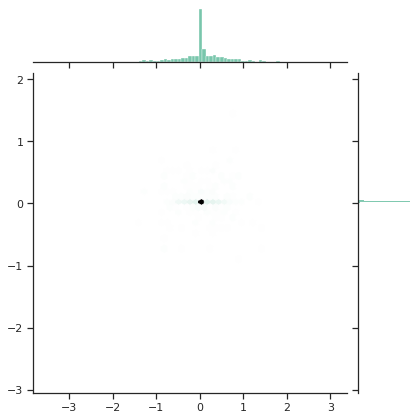

In [62]:
#### Testing the implementation

def plot_samples(tensor_data):
    data = np.array([[z[0].item(), z[1].item()] for z in tensor_data])
    sns.set_theme(style="ticks")
    graph = sns.jointplot(x=data[:,0], y=data[:,1], kind="hex", color="#4CB391")
    return graph

class SimpleModel:
    def __init__(self, mean, obs_dim):
        self.mean = mean
        scale_z = torch.diag(torch.ones(self.mean.size()))
        self.scale_x = torch.diag(torch.ones(obs_dim))
        self.dist_z = td.multivariate_normal.MultivariateNormal(self.mean, scale_z)

    def log_prob(self, obs, z):
        dist_x = td.multivariate_normal.MultivariateNormal(z, self.scale_x)
        return dist_x.log_prob(obs) + self.dist_z.log_prob(z)

train_data = [torch.tensor([5.4, 6.6]), 
              torch.tensor([6.4, 7.6]), 
              torch.tensor([4.0, 4.9]), 
              torch.tensor([4.2, 5.6])]


# start a new instance of the model and the implicit_uivi class
test_model = SimpleModel(torch.tensor([5.0, 5.5]), 2)
test_uivi = implicit_vi_student(test_model, theta_dim=5, n_samples_epsilon=2, n_runs=10)

# sample the posterior samples (with their mean) before training
z_posterior = test_uivi.sample_posterior(1000)
print(torch.mean(torch.stack(tuple(z_posterior)), axis=0))
plot_samples(z_posterior)

In [63]:
losses_student = test_uivi.test_train(train_data, n_epochs = 100, lr=0.01, trace_loss=True)
# sample the posterior samples (with their mean) after training
z_posterior = test_uivi.sample_posterior(1000)
print(f" mean of the posterior ={torch.mean(torch.stack(tuple(z_posterior)), axis=0)}")
plot_samples(z_posterior)

RuntimeError: ignored

In [ ]:
pd.DataFrame(losses_student, columns=["elbo"]).plot()

## Full implementation

In [52]:
class implicit_vi:
    def __init__(self, model, in_dim=3, z_dim=2, theta_dim=5, n_samples_epsilon=5, n_runs=10):
        self.in_dim = in_dim
        self.z_dim = z_dim
        self.theta_dim = theta_dim
        self.n_samples_epsilon = n_samples_epsilon
        self.n_runs = n_runs

        self.epsilon = td.multivariate_normal.MultivariateNormal(torch.zeros(self.in_dim), torch.diag(torch.ones(self.in_dim)))
        self.model = model
        self.initial_epsilon = None
        self.current_q_conditional = None

        # location parameter of q(z | epsilon)
        self.q_loc = nn.Sequential(nn.Linear(self.in_dim, self.theta_dim), nn.ReLU(), 
                                   nn.Linear(self.theta_dim, self.theta_dim), nn.ReLU(),
                                   nn.Linear(self.theta_dim, self.z_dim))
        # scale parameter
        #self.q_scale = nn.Sequential(nn.Linear(self.in_dim, self.z_dim), nn.ReLU(), nn.Threshold(0.000001, 0.000001))
        self.q_scale = nn.Sequential(nn.Linear(self.in_dim, self.theta_dim), nn.ReLU(), nn.Linear(self.theta_dim,
                                                                                                  2* self.z_dim),
                                     nn.ReLU(), nn.Threshold(0.001, 0.001),
                                     nn.Unflatten(dim=0, unflattened_size=(2, self.z_dim)))

    def q_z_conditional_epsilon(self, epsilon_s):
        # q_theta( z | f(epsilon))
        # this could be simply a diagonal matrix
        scale_mat = torch.matmul(self.q_scale(epsilon_s)[0].unsqueeze(1), self.q_scale(epsilon_s)[0].unsqueeze(1).t())
        scale_mat = scale_mat + torch.diag(self.q_scale(epsilon_s)[1])
        #scale_mat = torch.diag(self.q_scale(epsilon_s))
        #scale_mat = torch.diag(self.q_scale(epsilon_s))

        q_z_epsilon = td.multivariate_normal.MultivariateNormal(self.q_loc(epsilon_s),  covariance_matrix=scale_mat)

        return q_z_epsilon

    def parameters(self):
        return list(self.q_scale.parameters()) + list(self.q_loc.parameters())

    def sample_epsilon(self):
        epsilon = self.epsilon.rsample()
        self.initial_epsilon = epsilon.detach().numpy()
        self.current_q_conditional = self.q_z_conditional_epsilon(epsilon)
        return epsilon

    def sample_z(self, epsilon):
        conditional_q = self.q_z_conditional_epsilon(epsilon)
        z_s = conditional_q.rsample()
        return z_s

    def forward(self):
        epsilon = self.sample_epsilon()
        z_s = self.sample_z(epsilon)
        return z_s

    def sample_posterior(self, n_samples=5):
        ## auxiliary function for returning z after training for plotting
        res = []
        with torch.no_grad():
            for _ in range(n_samples):
                z = self.forward()
                res.append(z)
        return res

    def grad_z_log_q_z(self, z_s):
        # Equation 8: sum_{epsilon_s ~ q(epsilon | z)} nabla_z [ q_theta(z | epsilon_s) ]
        # z_s is a variable that has required_grad = True
        samples = self.hmc_sample_epsilons_from_q_epsilon_conditional_z_s(z_s)
        grads = []
        for epsilon_s_posterior_q in samples:
            conditional_q = self.q_z_conditional_epsilon(epsilon_s_posterior_q)
            log_prob = conditional_q.log_prob(z_s)
            grad = torch.autograd.grad(log_prob, z_s)[0].detach().numpy()

            grads.append(grad)
        return np.mean(grads, axis=0)

    def hmc_sample_epsilons_from_q_epsilon_conditional_z_s(self, z_s):
        if self.initial_epsilon is None:
            p0 = np.random.rand(1, self.in_dim)
        else:
            p0 = self.initial_epsilon
        sampler = hmc(self.__hmc_sampler_log_prob__, x0=p0, args=(z_s,), n_samples=5)
        sampler = hmc(self.__hmc_sampler_log_prob__, x0=sampler[-1], args=(z_s,), n_samples=self.n_runs)
        return [torch.tensor(epsilon_s).float() for epsilon_s in sampler]

    def __hmc_sampler_log_prob__(self, x, z):
        epsilon_s = Variable(torch.tensor(x).float(), requires_grad=True)
        q_z_epsilon = self.q_z_conditional_epsilon(epsilon_s)
        logprob = self.epsilon.log_prob(epsilon_s) + q_z_epsilon.log_prob(z)
        grad = torch.autograd.grad(logprob, epsilon_s)[0].detach().numpy()
        return logprob.detach().numpy().astype('double'), grad.astype('double')

    def implicit_loss(self, obs, z_s, trace_loss=False):
        computed_loss = None

        # nabla_z[log p] and nabla_z[log q]
        z = Variable(z_s.detach(), requires_grad=True)  ## needs to be a variable to calculate gradients
        grad_z_log_q = torch.tensor(self.grad_z_log_q_z(z)).detach()
        grad_z_log_p = torch.autograd.grad(self.model.log_prob(obs, z), z)[0].detach()
        g_theta_mod = torch.einsum('i...,i...->...', grad_z_log_p,
                                   z_s)  # grad_z_log_p x h_theta
        g_theta_ent = -torch.einsum('i...,i...->...', grad_z_log_q,
                                    z_s)  # -grad_z_log_q x h_theta
        loss = g_theta_ent + g_theta_mod
        if trace_loss:
            computed_loss = 0.0
            computed_loss += -self.current_q_conditional.log_prob(z).detach().sum() + self.model.log_prob(obs,z).detach().sum()
            computed_loss = computed_loss.numpy()

        # the derivative of this loss with respect to the network parameters is equivalent
        # to the derivative of the ELBO with respect to the parameters, since we want to maximize the elbo,
        # we add a negative term multiplied here because the optimizer will try to minimize it
        return -loss.sum(), computed_loss

    def test_train(self, dataset, n_epochs=10, lr=0.0001, trace_loss=False, use_uivi = True, **kargs):
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in tqdm(range(n_epochs)):
            epoch_implicit_loss = 0.0
            epoch_running_loss = 0.0
            for obs in dataset:
                optimizer.zero_grad()
                loss_sum = 0.0
                running_loss = 0.0
                for _ in range(self.n_samples_epsilon):
                    z = self.forward()
                    if use_uivi:
                        loss, trace_loss = self.implicit_loss(obs, z, trace_loss=trace_loss)
                    else:
                        loss, trace_loss = self.sivi_loss(obs, z, trace_loss=trace_loss, **kargs)
                    loss_sum += loss
                    if trace_loss:
                        running_loss += trace_loss
                loss_sum = loss_sum / self.n_samples_epsilon
                loss_sum.backward()
                optimizer.step()
                #for x in list(self.parameters()):
                #    x.data = torch.nan_to_num(x.data)

                epoch_implicit_loss += loss_sum.detach().item()
                if trace_loss:
                    running_loss = running_loss / self.n_samples_epsilon
                    epoch_running_loss += running_loss
            epoch_running_loss = epoch_running_loss / len(dataset)
            epoch_implicit_loss = epoch_implicit_loss / len(dataset)
            losses.append( [epoch_running_loss ] )
            if trace_loss:
                if epoch % 10 == 0:
                    print('Epoch: {}/{}, ELBO: {:.3f} '.format(epoch + 1, n_epochs,
                                                                         epoch_running_loss))
        return losses

    def sivi_lb_grad_z(self, obs, z_s, l_tightness=10):
        z_s = Variable(z_s.detach(), requires_grad=True)
        samples = [(lambda x:self.epsilon.rsample())(x) for x in range(l_tightness)]
        #print(samples)
        values_q = []
        values_p = []
        for epsilon_s in samples:
            conditional_q = self.q_z_conditional_epsilon(epsilon_s)
            log_q_prob = conditional_q.log_prob(z_s)
            log_p_prob = self.model.log_prob(obs, z_s)
            values_q.append(log_q_prob)
            values_p.append(log_p_prob)
        values_q.append(self.current_q_conditional.log_prob(z_s))
        values_q = torch.stack(tuple(values_q))
        log_approx = torch.logsumexp(values_q, 0)-torch.log(torch.tensor([l_tightness+1]))
        log_model = torch.stack(tuple(values_p)).mean(axis=0)
        grad_z_log_p = torch.autograd.grad(log_model, z_s)[0].detach()
        grad_z_log_q = torch.autograd.grad(log_approx, z_s)[0].detach()
        return grad_z_log_q, grad_z_log_p

    def sivi_loss(self, obs, z_s, trace_loss=False, l_tightness=10):
        computed_loss = None

        # nabla_z[log p] and nabla_z[log q]
        grad_z_log_q, grad_z_log_p = self.sivi_lb_grad_z(obs, z_s, l_tightness)

        g_theta_mod = torch.einsum('i...,i...->...', grad_z_log_p,
                                   z_s)  # grad_z_log_p x h_theta
        g_theta_ent = -torch.einsum('i...,i...->...', grad_z_log_q,
                                    z_s)  # -grad_z_log_q x h_theta
        loss = g_theta_ent + g_theta_mod
        if trace_loss:
            computed_loss = 0.0
            computed_loss += -self.current_q_conditional.log_prob(z_s).detach().sum() + self.model.log_prob(obs,
                                                                                                          z_s).detach()
            computed_loss = computed_loss.numpy()

        # the derivative of this loss with respect to the network parameters is equivalent
        # to the derivative of the ELBO with respect to the parameters, since we want to maximize the elbo,
        # we add a negative term multiplied here because the optimizer will try to minimize it
        return -loss.sum(), computed_loss.sum()


In [53]:
def plot_samples(tensor_data):
    data = np.array([[z[0].item(), z[1].item()] for z in tensor_data])
    sns.set_theme(style="ticks")
    graph = sns.jointplot(x=data[:,0], y=data[:,1], kind="hex", color="#4CB391")
    return graph

class SimpleModel:
    def __init__(self, mean, obs_dim):
        self.mean = mean
        scale_z = torch.diag(torch.ones(self.mean.size()))
        self.scale_x = torch.diag(torch.ones(obs_dim))
        self.dist_z = td.multivariate_normal.MultivariateNormal(self.mean, scale_z)

    def log_prob(self, obs, z):
        dist_x = td.multivariate_normal.MultivariateNormal(z, self.scale_x)
        return dist_x.log_prob(obs) + self.dist_z.log_prob(z)

train_data = [torch.tensor([5.4, 6.6]), 
              torch.tensor([6.4, 7.6]), 
              torch.tensor([4.0, 4.9]), 
              torch.tensor([4.2, 5.6])]

tensor([ 0.0095, -0.1507])


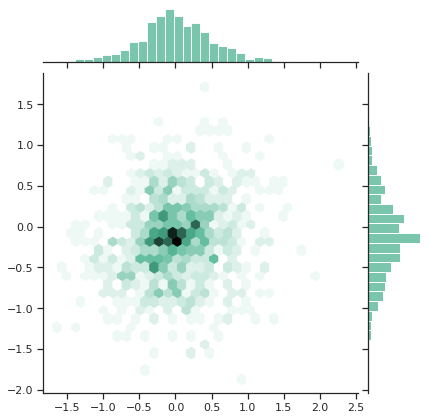

In [56]:
# start a new instance of the model and the implicit_uivi class
test_model = SimpleModel(torch.tensor([5.0, 5.5]), 2)
test_uivi = implicit_vi(test_model, theta_dim=5, n_samples_epsilon=2, n_runs=10)

# sample the posterior samples (with their mean) before training
z_posterior = test_uivi.sample_posterior(1000)
print(torch.mean(torch.stack(tuple(z_posterior)), axis=0))
plot_samples(z_posterior)

In [57]:
losses = test_uivi.test_train(train_data, n_epochs = 100, lr=0.01, trace_loss=True)

Epoch: 1/100, ELBO: -61.661 
Epoch: 11/100, ELBO: -4.599 
Epoch: 21/100, ELBO: -4.065 
Epoch: 31/100, ELBO: -3.282 
Epoch: 41/100, ELBO: -3.684 
Epoch: 51/100, ELBO: -4.447 
Epoch: 61/100, ELBO: -3.525 
Epoch: 71/100, ELBO: -3.524 
Epoch: 81/100, ELBO: -3.445 
Epoch: 91/100, ELBO: -3.584 



 mean of the posterior =tensor([4.8707, 5.6533])


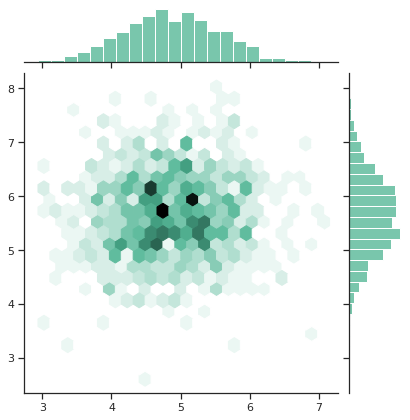

In [58]:
# sample the posterior samples (with their mean) before training
z_posterior = test_uivi.sample_posterior(1000)
print(f" mean of the posterior ={torch.mean(torch.stack(tuple(z_posterior)), axis=0)}")
plot_samples(z_posterior)

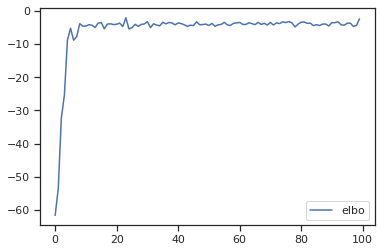

In [59]:
pd.DataFrame(losses, columns=["elbo"]).plot()

Sample: 100%|██████████| 1100/1100 [00:06, 175.95it/s, step size=8.81e-01, acc. prob=0.922]



                mean       std    median     25.0%     75.0%     n_eff     r_hat
      z[0]      5.05      0.49      5.07      4.87      5.52    378.79      1.00
      z[1]      6.04      0.46      6.05      5.78      6.37   1005.73      1.00

Number of divergences: 0
 mean of the posterior = tensor([5.0513, 6.0410])


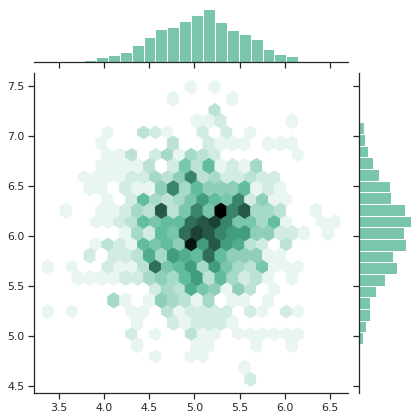

In [60]:
# Implement the same model in Pyro in order to compare with the result given by MCMC / HMC methods
import logging


import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

logging.basicConfig(format='%(message)s', level=logging.INFO)
pyro.set_rng_seed(0)


class SimpleModelPyro:
    def __init__(self, mean, obs_dim):
        self.mean = mean
        self.scale_z = torch.diag(torch.ones(self.mean.size()))
        self.scale_x = torch.diag(torch.ones(obs_dim))
        self.dist_z = td.multivariate_normal.MultivariateNormal(self.mean, self.scale_z)

    def log_prob(self, obs, z):
        dist_x = td.multivariate_normal.MultivariateNormal(z, self.scale_x)
        return dist_x.log_prob(obs) + self.dist_z.log_prob(z)

    def pyro_model(self, data):
        z = pyro.sample('z', dist.MultivariateNormal(self.mean, self.scale_z))
        return pyro.sample("x", dist.MultivariateNormal(z, self.scale_x), obs=data)
      
    def mcmc(self, data, num_samples=1000,warmup_steps=100 ):
        nuts_kernel = NUTS(self.pyro_model, jit_compile=True)
        mcmc = MCMC(nuts_kernel, num_samples=num_samples,
                    warmup_steps=warmup_steps,
                    num_chains=1)
        mcmc.run(data)
        mcmc.summary(prob=0.5)
        return mcmc

test_model_pyro = SimpleModelPyro(torch.tensor([5.0, 5.5]), 2)
res = test_model_pyro.mcmc(torch.stack(tuple(train_data)))

# posterior samples generated using pyro
print(f" mean of the posterior = {torch.mean(res.get_samples()['z'], axis=0)}")
plot_samples(res.get_samples()['z'])